# Ⅱ. skin数据集

初始化

In [12]:
import pandas as pd
import numpy as np
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_curve, auc
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
import os

In [2]:
example = pd.read_csv("data/skin/benchmarks/skin_benchmark_0001.csv")
example.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


从数据集中选取特征函数、获取训练集是否为离群点标签的函数

In [3]:
choosed_attrs = ["R","G","B"]
def str2bool(x):
    return 1 if x == "anomaly" else 0

def create_features(df):
    tmp = df.iloc[:,6:]
    return standardizer(tmp)
def get_label(df):
    y = df["ground.truth"]
    y = list(map(str2bool,y))
    return y

用于评价模型，输出并显示ROC曲线的函数

In [6]:
def show(title,clf_name, y, y_train_scores):
    evaluate_print(clf_name, y, y_train_scores)
    fpr, tpr, thresholds  =  roc_curve(y, y_train_scores) 
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## benchmark抽样分析

查看benchmark的元数据

In [8]:
meta = pd.read_csv('data/skin/meta_data/meta_skin.csv')
meta

,bench.id,benchnum,origin,mset,size,n.anom,n.norm,anomaly.rate.level,point.difficulty.level,clustering.algo,irrelevance.level,anomaly.rate,diff.mean,anom.diff.mean,norm.diff.mean,clusteredness.score,irrelevance.score,auc.ci.0.999,ap.ci.0.999
0,skin_benchmark_0001,1,binary,skin,6000,1217,4783,ar-0,pd-0,none,ir-0,0.202833,0.060019,0.084464,0.053800,1.077364,0.000000,0.525617,0.221824
1,skin_benchmark_0002,2,binary,skin,6000,1225,4775,ar-0,pd-0,none,ir-0,0.204167,0.058470,0.078569,0.053314,1.061695,0.000000,0.525605,0.223098
2,skin_benchmark_0003,3,binary,skin,6000,1245,4755,ar-0,pd-0,none,ir-0,0.207500,0.061087,0.087181,0.054254,1.043663,0.000000,0.525368,0.226587
3,skin_benchmark_0004,4,binary,skin,6000,1187,4813,ar-0,pd-0,none,ir-0,0.197833,0.056877,0.077470,0.051799,1.110271,0.000000,0.525846,0.216778
4,skin_benchmark_0005,5,binary,skin,6000,1241,4759,ar-0,pd-0,none,ir-0,0.206833,0.057646,0.079658,0.051906,1.011156,0.000000,0.525316,0.225858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,skin_benchmark_1736,1736,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333377,0.493219,0.315617,1.172648,1.236871,0.536514,0.115960
1496,skin_benchmark_1737,1737,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333343,0.489881,0.315950,1.208952,1.236117,0.536514,0.115960
1497,skin_benchmark_1738,1738,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333341,0.489209,0.316022,1.094585,1.244969,0.536514,0.115960
1498,skin_benchmark_1739,1739,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333339,0.495590,0.315311,1.275180,1.230456,0.536514,0.115960


选择skin_benchmark_0493、skin_benchmark_1267分析,使用PyOD工具包中的KNN, LOF, PCA, LODA对抽样个benchmark执行离群点检测，并可视化显示检测模型的评测结果。

In [69]:
examples = [
    "skin_benchmark_0493.csv",
      "skin_benchmark_1267.csv",
]
models = {
    "KNN": KNN(),
    "LOF": LOF(),
    "PCA": PCA(),
    "LODA": LODA(),
}
dfs = [pd.read_csv(os.path.join("data/skin/benchmarks",x)) for x in examples]

[0 0 0 ... 0 0 0]
KNN ROC:0.8115, precision @ rank n:0.0


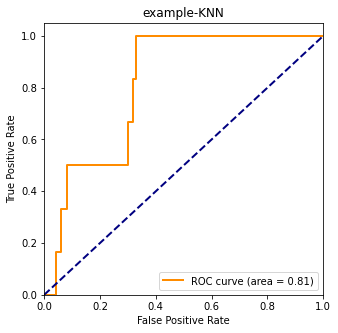

[0 0 0 ... 0 0 0]
LOF ROC:0.7922, precision @ rank n:0.0


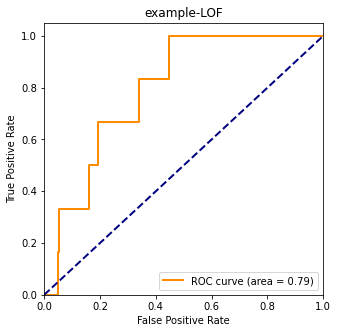

[0 0 0 ... 0 0 0]
PCA ROC:0.2389, precision @ rank n:0.0


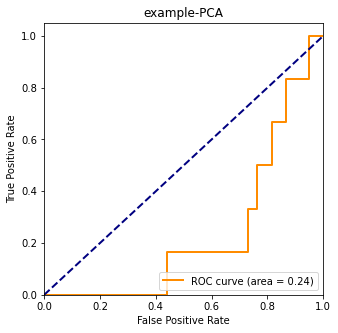

[0 0 0 ... 0 0 0]
LODA ROC:0.3019, precision @ rank n:0.0


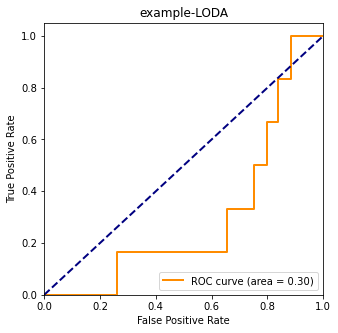

[0 0 0 ... 0 0 0]
KNN ROC:0.8591, precision @ rank n:0.0467


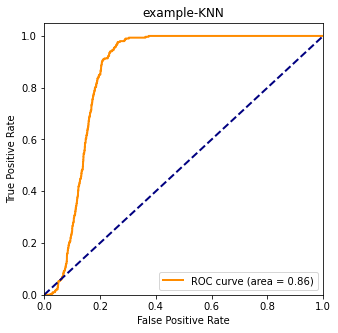

[0 0 0 ... 0 0 0]
LOF ROC:0.3424, precision @ rank n:0.0


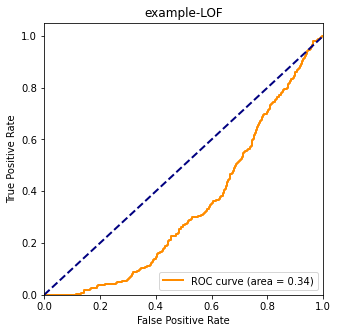

[1 0 0 ... 0 0 0]
PCA ROC:0.5498, precision @ rank n:0.0


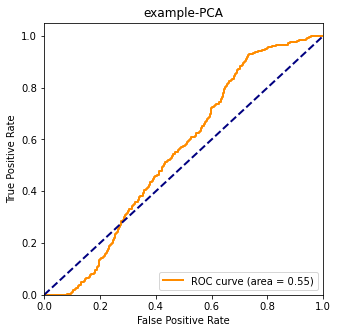

[0 0 0 ... 0 0 0]
LODA ROC:0.5675, precision @ rank n:0.04


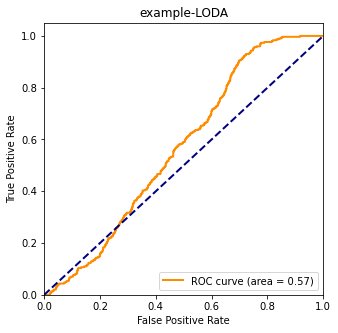

In [70]:
for df in dfs:
    x_train =  create_features(df)
    y_train =  get_label(df)
    c = y_train.count(1)/len(y_train)
    for k in models:
        clf_name = k
        clf = eval(k)(contamination = c)# 初始化检测器
        clf.fit(x_train)
        #得到训练数据的预测标签和离群值
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_ 
        print(y_train_pred)
        #输出结果
        show("%s-%s"%("example",clf_name),clf_name,y_train,y_train_scores)

## 所有benchmark的分析

In [71]:
import os
import time
benchmark_path = "data/skin/benchmarks"
#记录结果的DataFrame
result = pd.DataFrame({
    "benchmark":[],
    "model":[],
    "AUC":[],
    "precision @ rank":[],
    "time": []
})

for b in os.listdir(benchmark_path)[:40]:
    p = os.path.join(benchmark_path,b)
    df = pd.read_csv(p)
    x_train = create_features(df)
    y_train = get_label(df)
    c = y_train.count(1)/len(y_train)
    for k in models:
        t0 = time.time()
        clf_name = k
        clf = eval(k)(contamination = c)# 初始化检测器
        clf.fit(x_train)
        #得到训练数据的预测标签和离群值
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_ 
        #输出并写入DataFrame
        auc = round(roc_auc_score(y_train, y_train_scores), ndigits=4)
        prn = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
        t1 = time.time()
        duration = round(t1 - t0, ndigits=4)    
        tmp_dict = { "benchmark":b,"model":k,"AUC":auc,"precision @ rank":prn,"time": duration}
        print(tmp_dict)
        new = pd.DataFrame(tmp_dict, index=[1])
        result = result.append(new,ignore_index=True)

{'benchmark': 'skin_benchmark_0001.csv', 'model': 'KNN', 'AUC': 0.7181, 'precision @ rank': 0.2432, 'time': 0.051}
{'benchmark': 'skin_benchmark_0001.csv', 'model': 'LOF', 'AUC': 0.4534, 'precision @ rank': 0.1027, 'time': 0.101}
{'benchmark': 'skin_benchmark_0001.csv', 'model': 'PCA', 'AUC': 0.4572, 'precision @ rank': 0.0288, 'time': 0.022}
{'benchmark': 'skin_benchmark_0001.csv', 'model': 'LODA', 'AUC': 0.4417, 'precision @ rank': 0.0422, 'time': 0.1296}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'KNN', 'AUC': 0.7129, 'precision @ rank': 0.2327, 'time': 0.041}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'LOF', 'AUC': 0.4524, 'precision @ rank': 0.1412, 'time': 0.073}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'PCA', 'AUC': 0.4178, 'precision @ rank': 0.04, 'time': 0.02}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'LODA', 'AUC': 0.5285, 'precision @ rank': 0.1046, 'time': 0.1}
{'benchmark': 'skin_benchmark_0003.csv', 'model': 'KNN', 'AUC': 0.7211, 'precision

{'benchmark': 'skin_benchmark_0019.csv', 'model': 'KNN', 'AUC': 0.6201, 'precision @ rank': 0.2647, 'time': 1.1348}
{'benchmark': 'skin_benchmark_0019.csv', 'model': 'LOF', 'AUC': 0.5676, 'precision @ rank': 0.222, 'time': 1.4096}
{'benchmark': 'skin_benchmark_0019.csv', 'model': 'PCA', 'AUC': 0.4445, 'precision @ rank': 0.1191, 'time': 0.028}
{'benchmark': 'skin_benchmark_0019.csv', 'model': 'LODA', 'AUC': 0.4923, 'precision @ rank': 0.1625, 'time': 0.108}
{'benchmark': 'skin_benchmark_0020.csv', 'model': 'KNN', 'AUC': 0.6535, 'precision @ rank': 0.2823, 'time': 1.0692}
{'benchmark': 'skin_benchmark_0020.csv', 'model': 'LOF', 'AUC': 0.594, 'precision @ rank': 0.225, 'time': 1.3496}
{'benchmark': 'skin_benchmark_0020.csv', 'model': 'PCA', 'AUC': 0.4593, 'precision @ rank': 0.1432, 'time': 0.023}
{'benchmark': 'skin_benchmark_0020.csv', 'model': 'LODA', 'AUC': 0.4651, 'precision @ rank': 0.1252, 'time': 0.094}
{'benchmark': 'skin_benchmark_0021.csv', 'model': 'KNN', 'AUC': 0.7423, 'prec

{'benchmark': 'skin_benchmark_0037.csv', 'model': 'KNN', 'AUC': 0.6786, 'precision @ rank': 0.3454, 'time': 0.9071}
{'benchmark': 'skin_benchmark_0037.csv', 'model': 'LOF', 'AUC': 0.5629, 'precision @ rank': 0.2333, 'time': 1.1801}
{'benchmark': 'skin_benchmark_0037.csv', 'model': 'PCA', 'AUC': 0.5804, 'precision @ rank': 0.2724, 'time': 0.026}
{'benchmark': 'skin_benchmark_0037.csv', 'model': 'LODA', 'AUC': 0.5653, 'precision @ rank': 0.2809, 'time': 0.107}
{'benchmark': 'skin_benchmark_0038.csv', 'model': 'KNN', 'AUC': 0.7389, 'precision @ rank': 0.3789, 'time': 1.1089}
{'benchmark': 'skin_benchmark_0038.csv', 'model': 'LOF', 'AUC': 0.5334, 'precision @ rank': 0.2208, 'time': 1.3286}
{'benchmark': 'skin_benchmark_0038.csv', 'model': 'PCA', 'AUC': 0.6335, 'precision @ rank': 0.2828, 'time': 0.024}
{'benchmark': 'skin_benchmark_0038.csv', 'model': 'LODA', 'AUC': 0.5945, 'precision @ rank': 0.2573, 'time': 0.104}
{'benchmark': 'skin_benchmark_0039.csv', 'model': 'KNN', 'AUC': 0.7306, 'p

In [73]:
result.to_csv("output/skin_result.csv")

## 结果分析

In [72]:
result

,benchmark,model,AUC,precision @ rank,time
0,skin_benchmark_0001.csv,KNN,0.7181,0.2432,0.0510
1,skin_benchmark_0001.csv,LOF,0.4534,0.1027,0.1010
2,skin_benchmark_0001.csv,PCA,0.4572,0.0288,0.0220
3,skin_benchmark_0001.csv,LODA,0.4417,0.0422,0.1296
4,skin_benchmark_0002.csv,KNN,0.7129,0.2327,0.0410
...,...,...,...,...,...
155,skin_benchmark_0039.csv,LODA,0.5701,0.1953,0.1080
156,skin_benchmark_0040.csv,KNN,0.7330,0.3686,1.0051
157,skin_benchmark_0040.csv,LOF,0.5227,0.2138,1.2716
158,skin_benchmark_0040.csv,PCA,0.6382,0.2932,0.0240


In [74]:
result_knn = result[result["model"]=="KNN"]
print(result_knn.mean())
print(result_knn.max())

AUC                 0.692453
precision @ rank    0.275473
time                0.329732
dtype: float64
benchmark           skin_benchmark_0040.csv
model                                   KNN
AUC                                    0.75
precision @ rank                     0.3789
time                                 1.1348
dtype: object


In [75]:
result_lof = result[result["model"]=="LOF"]
print(result_lof.mean())
print(result_lof.max())

AUC                 0.462570
precision @ rank    0.145435
time                0.450595
dtype: float64
benchmark           skin_benchmark_0040.csv
model                                   LOF
AUC                                   0.594
precision @ rank                     0.2333
time                                 1.4096
dtype: object


In [76]:
result_pca = result[result["model"]=="PCA"]
print(result_pca.mean())
print(result_pca.max())

AUC                 0.556698
precision @ rank    0.200435
time                0.019173
dtype: float64
benchmark           skin_benchmark_0040.csv
model                                   PCA
AUC                                  0.7723
precision @ rank                      0.467
time                                  0.028
dtype: object


In [77]:
result_loda = result[result["model"]=="LODA"]
print(result_loda.mean())
print(result_loda.max())

AUC                 0.568947
precision @ rank    0.201280
time                0.118265
dtype: float64
benchmark           skin_benchmark_0040.csv
model                                  LODA
AUC                                  0.8483
precision @ rank                      0.619
time                                  0.169
dtype: object


可视化显示

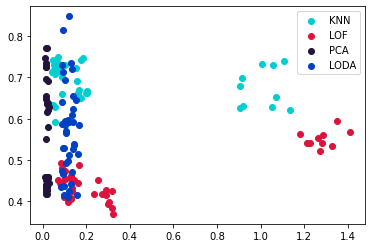

In [79]:
colors1 = '#00CED1' 
colors2 = '#DC143C'
colors = ["#00CED1","#DC143C","#22143C","#0040C2"]
plt.scatter(x=result_knn["time"], y= result_knn["AUC"], c=colors[0])
plt.scatter(x=result_lof["time"], y= result_lof["AUC"], c=colors[1])
plt.scatter(x=result_pca["time"], y= result_pca["AUC"], c=colors[2])
plt.scatter(x=result_loda["time"], y= result_loda["AUC"], c=colors[3])
plt.legend(["KNN","LOF","PCA","LODA"])
plt.show()

KNN算法的表现相对要最好，LOF的表现较差。